# use MNIST to test the autoencoder

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

import tensorflow as tf
from tensorflow.keras import datasets, optimizers, Sequential, metrics, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input, ReLU, Lambda
from tensorflow.keras import backend as K

from keras.datasets import mnist
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [6]:
input_img= Input(shape=(784,))

In [32]:
input_shape = (784,)
enc_layers = [256,128,64]
dec_layers = [128,256]
# regularization = 1e-2
learn_rate = 1e-5
loss = 'binary_crossentropy'

In [33]:
class PredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, cp_test_indiv, prediction_frequency=2):      
        super().__init__()
        
        self.P_test = cp_test_indiv
        self.prediction_frequency = prediction_frequency

        self.epoch_predictions = []
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.prediction_frequency == 0:
            predictions = self.model.predict(self.P_test)
            self.epoch_predictions.append(predictions)

def build_autoencoder(input_shape, enc_layers, dec_layers, regularization, learn_rate, loss):
    # Define the encoder layers
    encoder_inputs = Input(shape=input_shape[0])
    encoded = Dense(enc_layers[0])(encoder_inputs)
    encoded = ReLU()(encoded)
    for i in range(1, len(enc_layers)):
        encoded = Dense(enc_layers[i])(encoded)
        encoded = ReLU()(encoded)
    encoder_outputs = encoded

    # Define the decoder layers
    decoded = Dense(dec_layers[0])(encoder_outputs) 
    decoded = ReLU()(decoded) 
    for i in range(1, len(dec_layers)):
        decoded = Dense(dec_layers[i])(decoded)
        decoded = ReLU()(decoded)
    decoder_outputs = Dense(input_shape[0])(decoded)
    decoder_outputs = decoder_outputs = Activation('sigmoid')(decoder_outputs) # for test, using MNIST

    # Define the autoencoder model
    encoder = Model(encoder_inputs, encoder_outputs, name='encoder')
    autoencoder_outputs = decoder_outputs
    autoencoder = Model(encoder_inputs, autoencoder_outputs, name='autoencoder')
    
    adam = optimizers.Adam(learning_rate=learn_rate)

    # Compile the model
    autoencoder.compile(optimizer=adam, loss=loss)

    return autoencoder, encoder

print('Done!')

Done!


In [34]:
# Build the model
autoencoder, encoder = build_autoencoder(input_shape, enc_layers, dec_layers, regularization, learn_rate, loss)

In [35]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_18 (Dense)            (None, 256)               200960    
                                                                 
 re_lu_5 (ReLU)              (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 re_lu_6 (ReLU)              (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 re_lu_7 (ReLU)              (None, 64)                

In [36]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_18 (Dense)            (None, 256)               200960    
                                                                 
 re_lu_5 (ReLU)              (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 re_lu_6 (ReLU)              (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 re_lu_7 (ReLU)              (None, 64)                0   

In [37]:
autoencoder.fit(X_train, X_train,
                epochs=60,
                batch_size=256,
                shuffle=True)

Epoch 1/60
235/235 [==============================] - 2s 6ms/step - loss: 0.6713
Epoch 2/60
235/235 [==============================] - 1s 6ms/step - loss: 0.4707
Epoch 3/60
235/235 [==============================] - 1s 6ms/step - loss: 0.3132
Epoch 4/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2848
Epoch 5/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2764
Epoch 6/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2713
Epoch 7/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2669
Epoch 8/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2626
Epoch 9/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2577
Epoch 10/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2525
Epoch 11/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2476
Epoch 12/60
235/235 [==============================] - 1s 6ms/step - loss: 0.2424
Epoch 13/60
235/235 [====

In [38]:
encoded_imgs = encoder.predict(X_test)
predicted = autoencoder.predict(X_test)

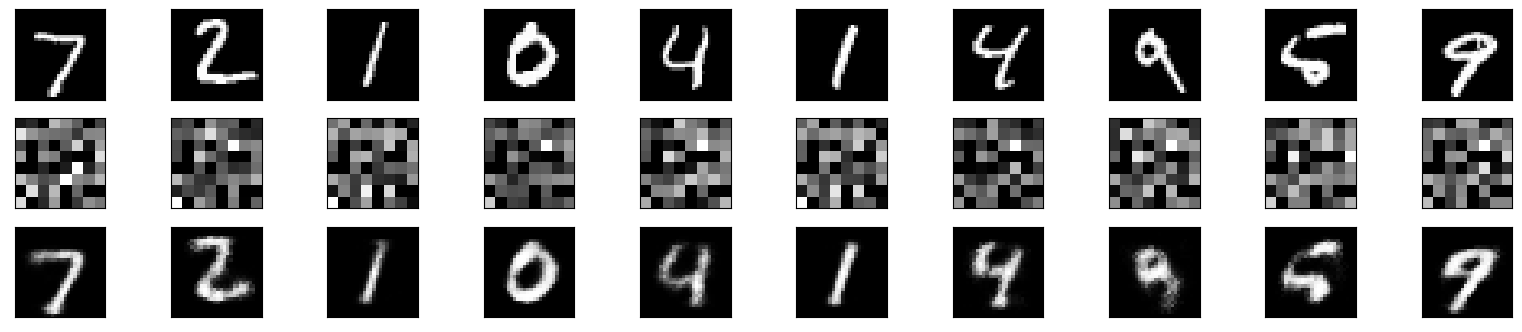

In [39]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(8,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

# add some noise to the input image and we will clip the values between 0 and 1

In [40]:
#loading only images and not their labels
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
X_train_noisy = X_train + np.random.normal(loc=0.0, scale=0.5, size=X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = X_test + np.random.normal(loc=0.0, scale=0.5, size=X_test.shape)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)
print(X_train_noisy.shape)
print(X_test_noisy.shape)

(60000, 784)
(10000, 784)


In [41]:
# Build the model
autoencoder, encoder = build_autoencoder(input_shape, enc_layers, dec_layers, regularization, learn_rate, loss)

In [42]:
# Fitting the noise trained data to the autoencoder 
autoencoder.fit(X_train_noisy, X_train_noisy,
                epochs=100,
                batch_size=256,
                shuffle=True)

Epoch 1/100
235/235 [==============================] - 2s 6ms/step - loss: 0.6760
Epoch 2/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5999
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5703
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5658
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5649
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5643
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5639
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5635
Epoch 9/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5629
Epoch 10/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5621
Epoch 11/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5610
Epoch 12/100
235/235 [==============================] - 1s 6ms/step - loss: 0.5595
Epoch 13/100


In [43]:
# reconstructing the image from autoencoder and encoder
encoded_imgs = encoder.predict(X_test_noisy)
predicted = autoencoder.predict(X_test_noisy)

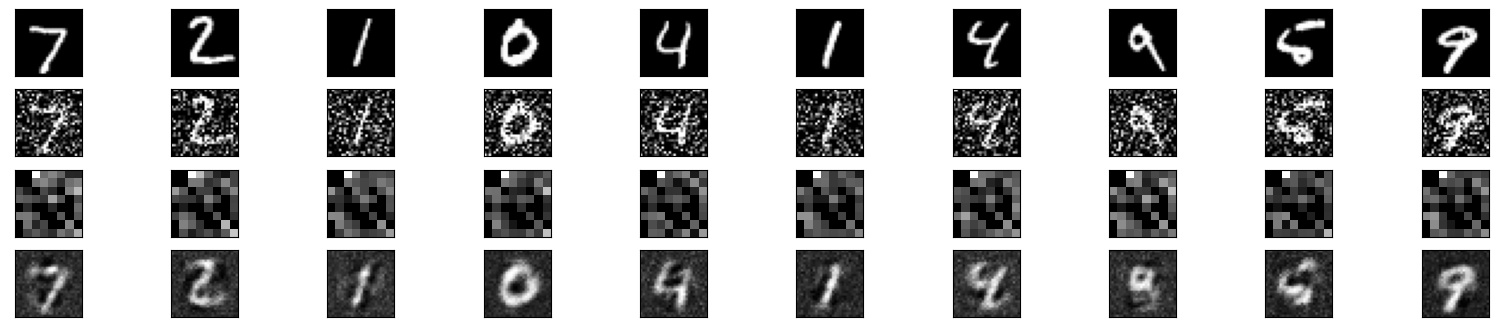

In [44]:
# plotting the noised image, encoded image and the reconstructed image
plt.figure(figsize=(40, 4))
for i in range(10):
# display original images
    
    ax = plt.subplot(4, 20, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display noised images
    ax = plt.subplot(4, 20, i + 1+20)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display encoded images    
    ax = plt.subplot(4, 20, 2*20+i + 1 )
    plt.imshow(encoded_imgs[i].reshape(8,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display reconstruction images
    ax = plt.subplot(4, 20, 3*20 +i+ 1)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()